In [1]:
import pandas as pd

In [2]:
## Load Data
DATA_PATH = 'data/raw/first_graph.csv'
data = pd.read_csv(DATA_PATH)
data.head()

,Unnamed: 0,from,to,weight,color,from_name,from_class,from_shape,from_color,from_vertex.frame.color,to_name,to_class,to_shape,to_color,to_vertex.frame.color
0,1,1,6,0.668212,darkred,5104-SL-0188,1,sphere,1,white,5104-SL-3299,2,sphere,2,white
1,2,1,7,0.543382,darkred,5104-SL-0188,1,sphere,1,white,5104-SL-1080,1,sphere,1,white
2,3,1,9,0.487524,darkred,5104-SL-0188,1,sphere,1,white,5104-SL-2263,1,sphere,1,white
3,4,1,12,0.508775,darkred,5104-SL-0188,1,sphere,1,white,5104-SL-0324,1,sphere,1,white
4,5,1,13,0.466904,darkred,5104-SL-0188,1,sphere,1,white,5104-SL-0391,1,sphere,1,white


(array([ 9319.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15674.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

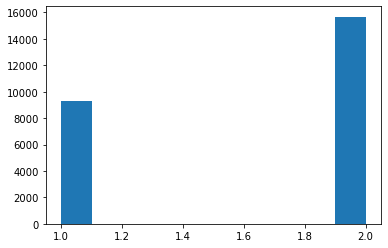

In [3]:
import matplotlib.pyplot as plt
plt.hist(data['to_class'])

In [4]:
import torch
import torch_geometric
print('Torch Version : %s' % torch.__version__ )
print('Cuda available : %s' % torch.cuda.is_available())
print('Torch geometric version : %s' % torch_geometric.__version__)

Torch Version : 1.12.0+cu116
Cuda available : True
Torch geometric version : 2.1.0


In [5]:
from torch_geometric.data import Data , download_url , Dataset 
import numpy as np
import os
import os.path as osp 
from tqdm import tqdm
import networkx as nx
import random

In [6]:
class PDDataset(Dataset):
    def __init__(self , root , split = None , transform =None, pre_transform=None):
        """
        root = Where data should be stored. This folder is split into 
        raw_dir (downloaded dataset) and preprocessed_dir (processed data)
        """
        self.split = split
        super(PDDataset , self).__init__(root , transform, pre_transform)
        self.data  = torch.load(osp.join(self.processed_paths[0]))
        print(self.data)

    
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (the download func is not implemented here)
        """
        return 'first_graph.csv'

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped
        """
        return ['data_0.pt']

    def download(self):
        # Download to `self.raw_dir`.
        #path = download_url(url, self.raw_dir)
        """ Could in future link this to big.inf.ed.ac.uk server? 
        """
        pass

    def process(self):
        
        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`
            self.data = pd.read_csv(self.raw_paths[idx])
            G = nx.Graph()
            
            nodes = self.data['from'].append(self.data['to']).drop_duplicates()
            nodes = nodes.reset_index(drop=True) - 1
            G.add_nodes_from(nodes)

            edges = []
            for edge1 , edge2 in zip(self.data['from'] , self.data['to']) : 
                    edges.append((edge1 - 1 ,edge2 - 1))
                    edges.append((edge2 - 1 ,edge1 - 1))

            G.add_edges_from(edges)
            
            # Get Node Features
            node_feats = self._get_node_features(G)
            # Get Edge Features
            edge_feats = self._get_edge_features(G)
            #Get Edge Weights
            edge_weights = self._get_edge_weight(G)
            # Get adjacency info
            edge_index = self._get_adjacency_info(G)
            #Get labels info
            label = self._get_labels(G)
            
            
            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        edge_weight = edge_weights,
                        y=label,
                        ) 
            
            if self.split == True : 
                train_mask , test_mask , val_mask = self._train_test_split(len(data.y) , .8 , .1 , .1)
                data.train_mask = torch.Tensor(train_mask) == 1
                data.test_mask = torch.Tensor(test_mask) == 1
                data.val_mask = torch.Tensor(val_mask) == 1
                
            '''if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)'''

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1
            
    def _train_test_split(self, n  , split_train , split_test , split_val) :  
    
        mask = [i for i in range(0,n)]

        train_mask = random.sample(mask , int(n*split_train)-1)
        train_array = [False for i in range(0,n)]
        for item in train_mask : 
            train_array[item] = True

        test_mask = random.sample([i for i in mask if i not in train_mask] , int(n*split_test)-1)
        test_array = [False for i in range(0,n)]
        for item in test_mask : 
            test_array[item] = True

        val_mask = random.sample([i for i in mask if i not in (train_mask + test_mask)] , int(n*split_val)-1)
        val_array = [False for i in range(0,n)]
        for item in val_mask : 
            val_array[item] = True

        return train_array , test_array , val_array
        
    def _get_node_features(self , G) :
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        
        all_node_feats = []
        for node in G.nodes() :
            node_feats = []
            # Feature 1 Node Degree
            node_feats.append(nx.degree(G , node))
            #Feature 2 Node Centrality 
            node_feats.append(nx.closeness_centrality(G , node))
            
            all_node_feats.append(node_feats)
            
        
        return torch.tensor(all_node_feats , dtype = torch.float)
    
    def _get_edge_weight(self , G) : 
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, 1]
        """
        
        all_edge_weights = []
        idx = 0
        for edge in G.edges() : 
            # Feature 1 Edge Weight
            all_edge_weights.append(self.data['weight'][idx]*100)
            
            idx += 1
            
        return torch.tensor(all_edge_weights , dtype = torch.float)
        
    
    def _get_edge_features(self , G) :
        ''' This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        '''
            
        all_edge_feats = []
        idx = 0
        for edge in G.edges() : 
            edge_feat = []
            # Feature 1 Edge Type
            if (self.data['from_class'][idx] == 1) & (self.data['to_class'][idx] == 1) :
                edge_feat.append(0)
            elif (self.data['from_class'][idx] == 2) & (self.data['to_class'][idx] == 2) :
                edge_feat.append(1)
            else :
                edge_feat.append(2)
            # Feature 2 : Positive (1) or Negative Edge (2)
            if self.data['color'][idx] == 'darkblue' :
                edge_feat.append(0)
            else :
                edge_feat.append(1)
                
            all_edge_feats.append(edge_feat)
            idx += 1
            
        return torch.nn.functional.one_hot(torch.tensor(all_edge_feats))
    
    def _get_adjacency_info(self , G) :
        ''' Transform into edge index
        '''
        edge_indices = []
        for edge in G.edges() : 
            i = edge[0]
            j = edge[1]
            
            edge_indices += [i,j]
            
        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        
        return edge_indices
    
    def _get_labels(self , G) :
        label = []
        for node in G.nodes() : 
            if sum(self.data['from'] == node + 1) > 0 :
                label.append(self.data[self.data['from'] == node + 1]['from_class'].values[0] -1)
            else :
                label.append(self.data[self.data['to'] == node + 1]['to_class'].values[0] -1)
                
        label = np.asarray(label)
        
        return torch.tensor(label , dtype = torch.int64)
        
    def num_classes(self , idx) :
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data.num_features

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        """ Equivalent to __getitem__ in pytorch
            Is not needed for PYG's InMemory Dataset
        """
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data


In [8]:
dataset =  PDDataset(root = 'data/' , split = True )

Data(x=[311, 2], edge_index=[2, 24993], edge_attr=[24993, 2, 3], y=[311], edge_weight=[24993], train_mask=[311], test_mask=[311], val_mask=[311])


In [9]:
df = pd.read_csv('data/raw/first_graph.csv')
G = nx.Graph()

nodes = df['from'].append(df['to']).drop_duplicates()
nodes = nodes.reset_index(drop=True) - 1
G.add_nodes_from(nodes)

edges = []
for edge1 , edge2 in zip(df['from'] , df['to']) : 
        edges.append((edge1 - 1 ,edge2 - 1))
        edges.append((edge2 - 1 ,edge1 - 1))

G.add_edges_from(edges)

C:\Users\Barry\AppData\Local\Temp\ipykernel_25452\3434371000.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nodes = df['from'].append(df['to']).drop_duplicates()


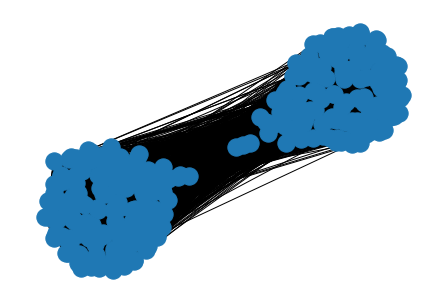

In [10]:
nx.draw(G)

In [11]:
all_edge_feats = []
idx = 0
for edge in G.edges() : 
    edge_feat = []
    # Feature 1 Edge Type
    if (df['from_class'][idx] == 1) & (df['to_class'][idx] == 1) :
        edge_feat.append(0)
    elif (df['from_class'][idx] == 2) & (df['to_class'][idx] == 2) :
        edge_feat.append(1)
    else :
        edge_feat.append(2)
    # Feature 2 : Positive (1) or Negative Edge (2)
    if df['color'][idx] == 'darkblue' :
        edge_feat.append(0)
    else :
        edge_feat.append(1)

    all_edge_feats.append(edge_feat)